# Question: Which features do you choose for X and why?

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import ElasticNet
from statsmodels.regression.linear_model import OLS
from sklearn import preprocessing
import math
from sklearn.ensemble import RandomForestRegressor as RDFR
from sklearn.ensemble import RandomForestClassifier as RDFC
from sklearn.linear_model import Ridge, RidgeCV, LassoCV,Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import seaborn.apionly as sns
from sklearn.decomposition import PCA
%matplotlib inline

In previous data preprocsssing step, we have transformed non-dichotomous categorical features to relative freqeuncies, and created a new response variable via clustering. Now we will use those preprocessed data for feature selection

In [17]:
result= pd.read_csv('imdb_cluster_result.csv')

In [52]:
result = result.drop('cast_4', 1)

In [54]:
result.head()

,X,certificates_R,certificates_PG,art.direction_1,assistant.director_1,casting.director_1,cinematographer_1,costume.department_1,costume.designer_1,countries_1,...,Action,Documentary,Musical,History,Family,Fantasy,Sport,Biography,cluster_response,genres_comb
0,100,1,0,0.322495,0.042103,0.010279,0.046254,0.307966,0.028662,0.089642,...,0,0,0,0,0,0,0,0,5,"Horror, Thriller, Action"
1,10001,0,1,0.027673,0.093694,0.319431,0.165250,0.307966,0.172860,0.014232,...,0,0,0,1,0,0,0,0,4,"Romance, Comedy, Fantasy"
2,10002,1,0,0.212394,0.024906,0.006523,0.016308,0.012453,0.005535,0.089642,...,0,0,0,0,0,0,0,0,1,"Horror, Thriller, Drama"
3,10003,0,1,0.019767,0.024906,0.014133,0.025301,0.126112,0.007116,0.536766,...,1,0,0,0,0,0,0,0,1,"Horror, Thriller, Drama"
4,10004,1,0,0.104764,0.355406,0.017395,0.049812,0.126112,0.040028,0.536766,...,0,0,0,0,0,1,0,0,1,"Horror, Thriller, Drama"


In [53]:
result.shape

(10118, 57)

## X

In [55]:
result.columns.values

array(['X', 'certificates_R', 'certificates_PG', 'art.direction_1',
       'assistant.director_1', 'casting.director_1', 'cinematographer_1',
       'costume.department_1', 'costume.designer_1', 'countries_1',
       'director_1', 'distributors_1', 'editor_1', 'languages_1',
       'make.up_1', 'miscellaneous.companies_1', 'miscellaneous.crew_1',
       'original.music_1', 'producer_1', 'production.companies_1',
       'production.manager_1', 'set.decoration_1', 'sound.crew_1',
       'stunt.performer_1', 'visual.effects_1', 'writer_1', 'cast_1',
       'cast_2', 'cast_3', 'runtimes_avg', 'rating', 'Sci.Fi', 'Crime',
       'Romance', 'Animation', 'Music', 'Adult', 'Comedy', 'War', 'Horror',
       'Film.Noir', 'Western', 'Thriller', 'Adventure', 'Mystery', 'Short',
       'Drama', 'Action', 'Documentary', 'Musical', 'History', 'Family',
       'Fantasy', 'Sport', 'Biography', 'cluster_response', 'genres_comb'], dtype=object)

## Y

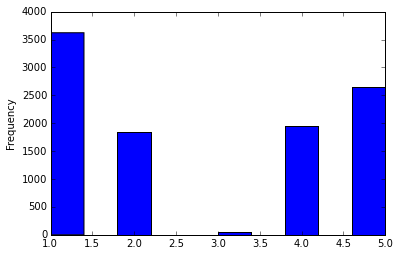

In [33]:
result['cluster_response'].plot(kind='hist')

In [56]:
X_train=result.ix[:,2:31].values
y=result['cluster_response'].values

In [57]:
X_train.shape

(10118, 29)

In [58]:
y.shape

(10118,)

# Feature Selection

1. Ridge Regression
2. LASSO Regression
3. Random Forest
4. PCA

### 1. Ridge Regression

#### Set RMSE as metrics

We assess how well these models perform with root-mean-square-error (RMSE) at log scale of predicted and observed sales prices. The reason for using RMSE as an evaluation method is because RMSE is the square root of the variance of the residuals. It indicates the absolute fit of the model to the data–how close the observed data points are to the model's predicted values. Compared to R-squared value which is a relative measure of fit, RMSE is an absolute measure of fit.

In [61]:
from sklearn.linear_model import Ridge, RidgeCV, LassoCV,Lasso
from sklearn.model_selection import cross_val_score
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)

In [62]:
num_lambdas = 100
lambdas= np.linspace(-7,7, num_lambdas)

cv_ridge = [rmse_cv(Ridge(alpha = 10**i)).mean() 
            for i in lambdas]

#### Cross-validation to tune paramters

Ridge Regression: min RMSE on training set 1.09864890645


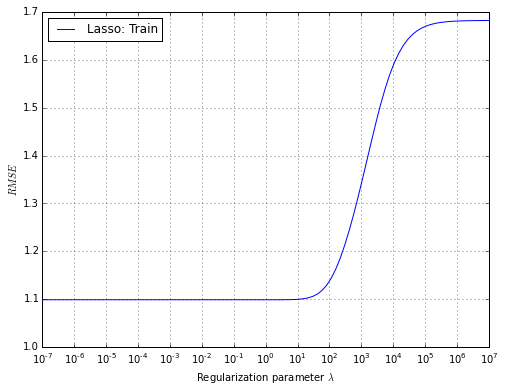

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.semilogx(10.0**lambdas, (cv_ridge), c='b', label='Lasso: Train')

ax.set_xlabel('Regularization parameter $\lambda$')
ax.set_ylabel(r'$RMSE$')

ax.grid()
ax.legend(loc = 'best')

print 'Ridge Regression: min RMSE on training set', min(cv_ridge)

#### Result of best ridge model

In [64]:
min_value = min(cv_ridge)
min_index = cv_ridge.index(min_value)

In [65]:
print "Lambda for min RMSE:", lambdas[min_index]

Lambda for min RMSE: 0.212121212121


In [66]:
best_ridge=Ridge(alpha = 10**(lambdas[min_index])).fit(X_train, y)

In [67]:
print "Min RMSE for Ridge Model:", rmse_cv(best_ridge).mean()

Min RMSE for Ridge Model: 1.09864890645


In [69]:
coef = pd.Series(best_ridge.coef_, index = result.columns[2:31])
newcoef=pd.DataFrame(coef)
newcoef_sorted = newcoef.sort_values(by=[0], ascending=[False])
imp_coef = pd.concat([newcoef_sorted.head(10),
                     newcoef_sorted.tail(10)])

In [70]:
color_selection = ['lightslategray','darkseagreen','palevioletred','gold','coral','skyblue','darkseagreen','palevioletred','gold','coral','skyblue','darkseagreen','palevioletred','gold','tan','lightslategray','darkseagreen','palevioletred','gold','coral']

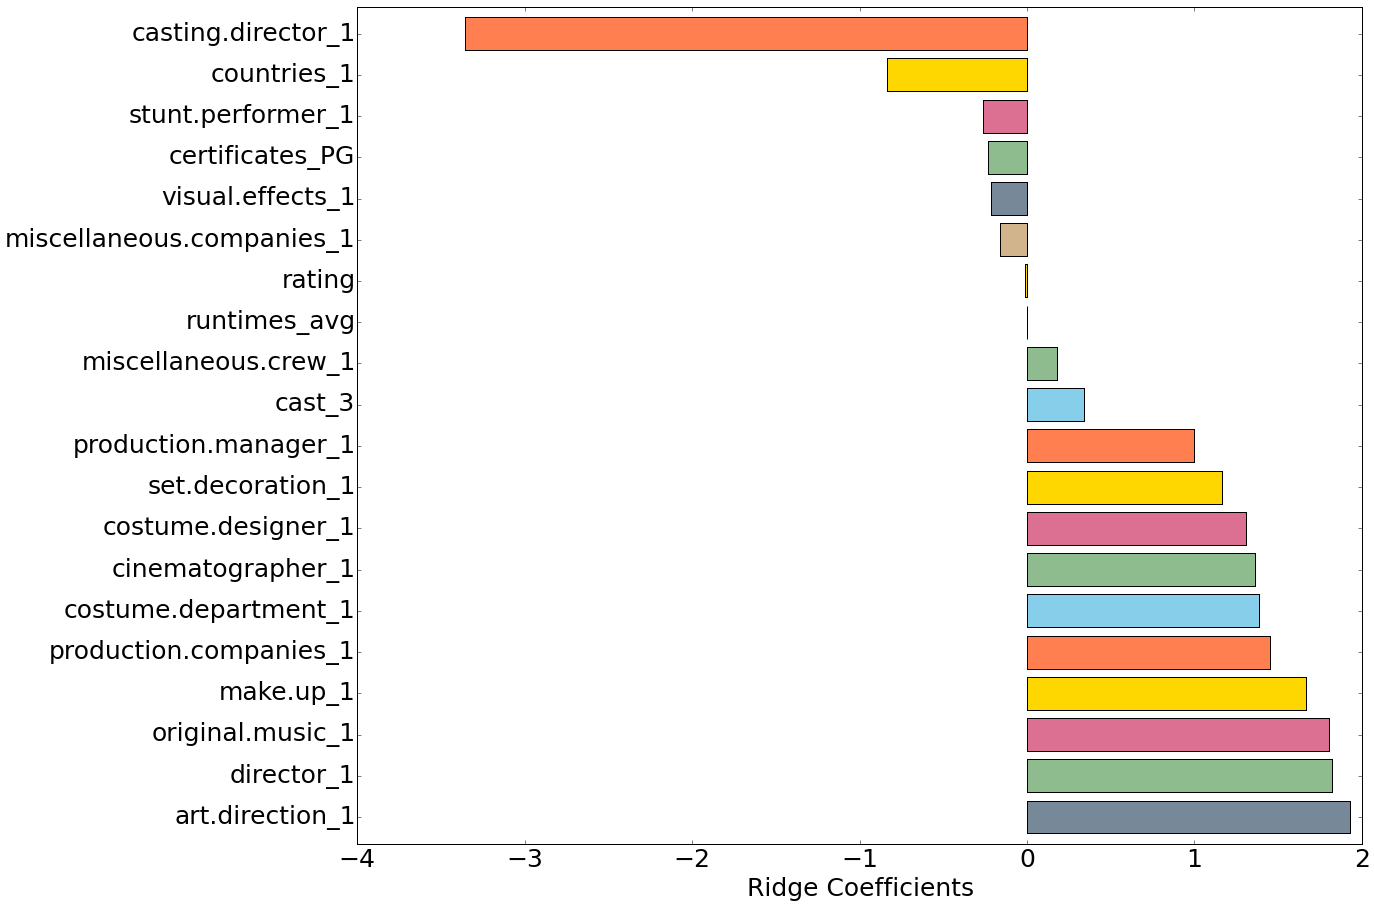

In [71]:
matplotlib.rcParams['figure.figsize'] = (18.0, 15.0)
imp_coef.plot(kind = "barh", color=color_selection,width = 0.8, legend=None, fontsize = 25)
plt.xlabel('Ridge Coefficients', fontsize = 25)

plt.show()

### Top 10 features with largest absolute coef estimates

In [72]:
imp_coef

,0
art.direction_1,1.930824
director_1,1.820137
original.music_1,1.804336
make.up_1,1.665570
production.companies_1,1.451200
costume.department_1,1.385061
cinematographer_1,1.365293
costume.designer_1,1.307607
set.decoration_1,1.164111
production.manager_1,0.996842


In [131]:
newcoef_sorted.columns=['coef']

In [141]:
newcoef_sorted['abs']=abs(newcoef_sorted['coef'])

Sort the features by absoulte coef estimtes

In [144]:
sort_ridge=newcoef_sorted.sort_values(['abs'],ascending=False)

### 2. LASSO

In [145]:
num_lambdas = 100
lambdas= np.linspace(-7,7, num_lambdas)

cv_lasso = [rmse_cv(Lasso(alpha = 10**i)).mean() 
            for i in lambdas]

Lasso Regression: min RMSE on training set 1.09869206889


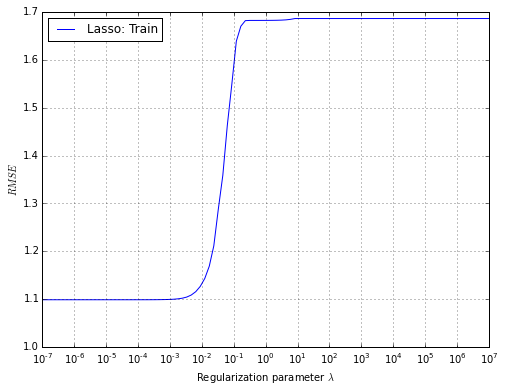

In [146]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.semilogx(10.0**lambdas, (cv_lasso), c='b', label='Lasso: Train')

ax.set_xlabel('Regularization parameter $\lambda$')
ax.set_ylabel(r'$RMSE$')

ax.grid()
ax.legend(loc = 'best')

print 'Lasso Regression: min RMSE on training set', min(cv_lasso)

In [147]:
min_value = min(cv_lasso)
min_index = cv_lasso.index(min_value)

In [148]:
best_lasso=Lasso(alpha = 10**(lambdas[min_index])).fit(X_train, y)

In [149]:
print "Lambda for min RMSE:", lambdas[min_index]

Lambda for min RMSE: -7.0


In [150]:
print "Min RMSE for Ridge Model:", rmse_cv(best_lasso).mean()

Min RMSE for Ridge Model: 1.09869206889


In [151]:
coef = pd.Series(best_lasso.coef_, index = result.columns[2:31])

In [152]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 29 variables and eliminated the other 0 variables


In [153]:
newcoef1=coef[coef != 0]
newcoef1=pd.DataFrame(newcoef1)
newcoef_sorted1 = newcoef1.sort_values(by=[0], ascending=[False])
imp_coef1 = pd.concat([newcoef_sorted1.head(10),
                     newcoef_sorted1.tail(10)])

In [154]:
color_selection = ['lightslategray','darkseagreen','palevioletred','gold','coral','skyblue','darkseagreen','palevioletred','gold','coral','skyblue','darkseagreen','palevioletred','gold','tan','lightslategray','darkseagreen','palevioletred','gold','coral']

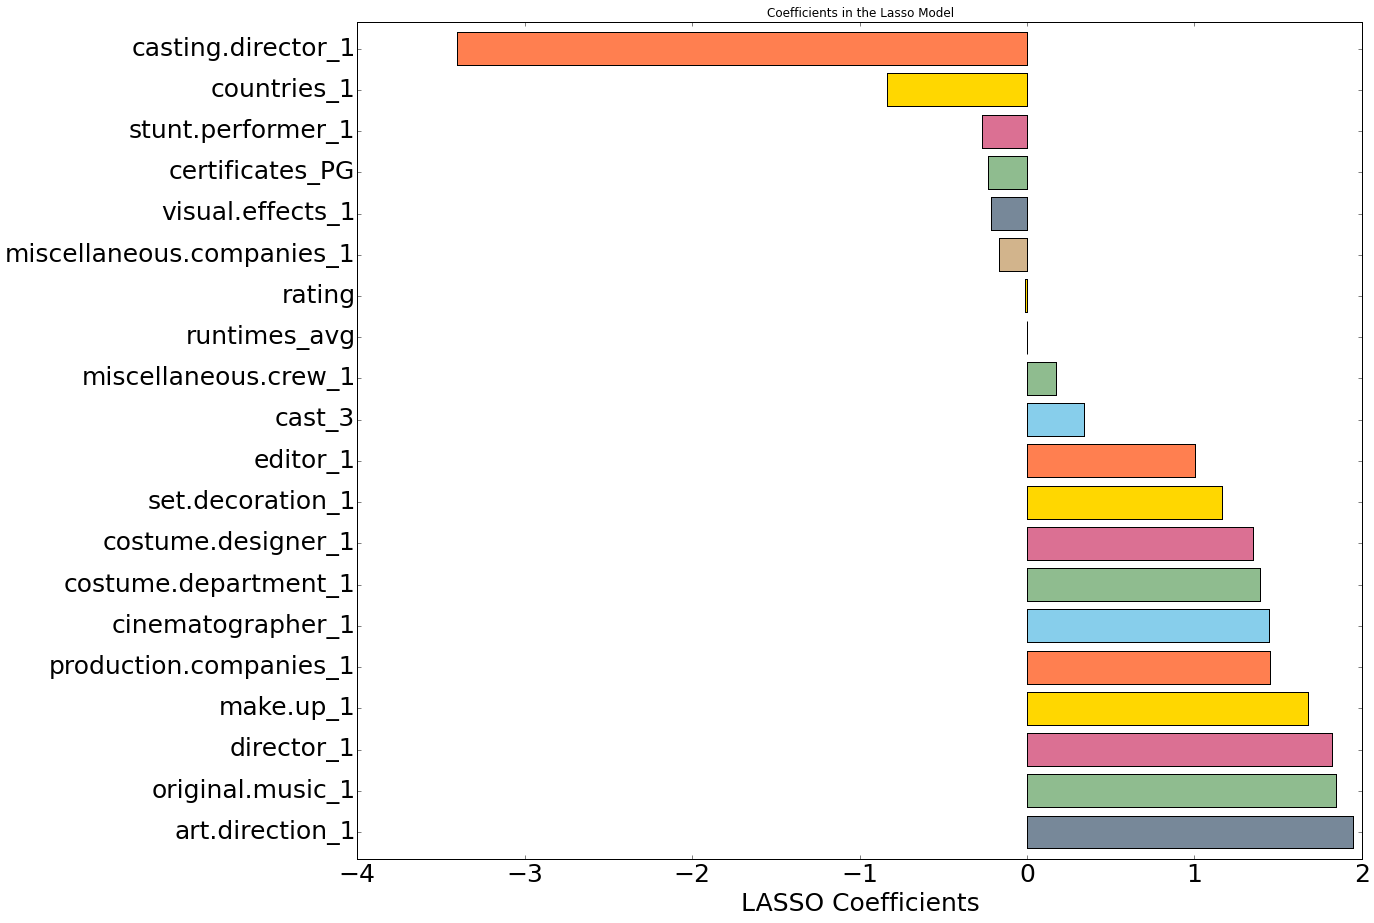

In [155]:
matplotlib.rcParams['figure.figsize'] = (18.0, 15.0)
imp_coef.plot(kind = "barh", color=color_selection,width = 0.8, legend=None, fontsize = 25)
plt.xlabel('LASSO Coefficients', fontsize = 25)
plt.title("Coefficients in the Lasso Model")
plt.show()

### Top 10 features with largest absolute coef

In [156]:
imp_coef1

,0
art.direction_1,1.945292
original.music_1,1.844986
director_1,1.825084
make.up_1,1.678207
production.companies_1,1.453250
cinematographer_1,1.446929
costume.department_1,1.393531
costume.designer_1,1.352806
set.decoration_1,1.162994
editor_1,1.002309


In [157]:
newcoef_sorted1.columns=['coef']

In [158]:
newcoef_sorted1['abs']=abs(newcoef_sorted1['coef'])

Sort the features by absoulte coef estimtes

In [159]:
sort_lasso=newcoef_sorted1.sort_values(['abs'],ascending=False)

### 3. Random Forest

In [91]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV

In [92]:
# A generic function to do CV
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)

    best = gs.best_estimator_
    results=gs.grid_scores_
    return best, results

In [93]:
clfForest = RandomForestClassifier(oob_score=True, max_features='auto')
clf=clfForest.fit(X_train, y)

#### Use cross-validatioon (5-fold) to find best depth and number of estimators

In [94]:
n=range(10,100,10)
m=range(1,20,2)
parameters = {"max_depth": m, 'n_estimators': n}
clf,result0 = cv_optimize(clfForest, parameters, X_train, y, n_jobs=10, n_folds=5, score_func=None);
print clf.max_depth, clf.n_estimators

15 90


In [95]:
clfForest = RandomForestClassifier(n_estimators=60, oob_score=True, max_features='auto', max_depth=5)

clf=clfForest.fit(X_train, y)
clf.score(X_train,y)

0.85402253409764772

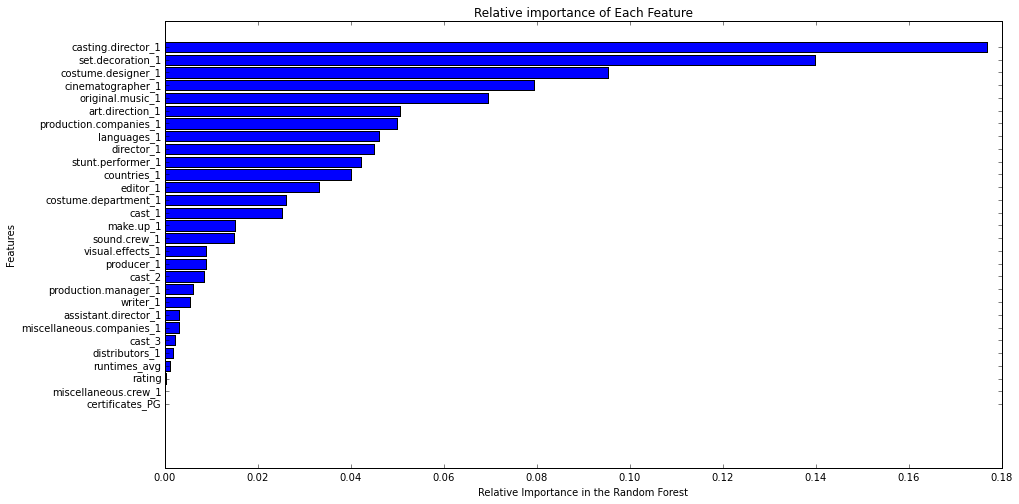

In [113]:
plt.figure(figsize=(15,8))
importance_list = clfForest.feature_importances_
name_list = result.columns[2:31]
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

In [184]:
coef_rf = pd.DataFrame(clfForest.feature_importances_, index = result.columns[2:31])

In [185]:
coef_rf.columns=['importance']

Sort the features by importance

In [186]:
sort_rf=coef_rf.sort_values(['importance'],ascending=False)

In [187]:
sort_rf

,importance
casting.director_1,0.176849
set.decoration_1,0.139823
costume.designer_1,0.095379
cinematographer_1,0.079484
original.music_1,0.069494
art.direction_1,0.050673
production.companies_1,0.049995
languages_1,0.046212
director_1,0.044994
stunt.performer_1,0.042182


## Top features selected by Ridge/Lasso/Random Forest

In [192]:
index=range(1,30)

In [196]:
summary= pd.DataFrame(sort_ridge.index.values,index=index)

In [197]:
summary.columns=['Ridge']

In [198]:
summary['Lasso']=sort_ridge.index.values

In [199]:
summary['RandomForest']=sort_rf.index.values

In [200]:
summary

,Ridge,Lasso,RandomForest
1,casting.director_1,casting.director_1,casting.director_1
2,art.direction_1,art.direction_1,set.decoration_1
3,original.music_1,original.music_1,costume.designer_1
4,director_1,director_1,cinematographer_1
5,make.up_1,make.up_1,original.music_1
6,production.companies_1,production.companies_1,art.direction_1
7,cinematographer_1,cinematographer_1,production.companies_1
8,costume.department_1,costume.department_1,languages_1
9,costume.designer_1,costume.designer_1,director_1
10,set.decoration_1,set.decoration_1,stunt.performer_1


## Summary

LASSO includes all the **29** features into the model, and it has same results with Ridge regression. The top 10 features selected by three methods are similar, while the reulst of random forest makes more sense in real life cases.

In general, the most important feautures related to genre are:
**casting director**, **set decoration**, **cinematographer**, **art direction**, **original music**, **production.companies**, **director**, **languages**, **stunt performer**.

In the movie industry, a **casting director** is reponsible for selecting a certain type of actor. It seems that the casting director for different genres of movies have specific perferences on actors. So that's why casting director is closely related to movie genres. Also, **set decoration**, **art direction** and **original music** differ a lot in genres, for example romance and thriller have complete differnt settings and music. **Cinematographer** is a person who oversees or directs photography and camerawork in movie-making. The shooting skills and expertise required for a cinematographer are also highly depend on movie genres. Not surprisingly, **production.companies**, **director** are also two important feature for genre classfication. Some production companies/directors are good at producing/directing certain genres of movies. For example, the movie produced by Walt Disney are mostly comedy and fantasy. Only certain genres of movie (adventure, action, etc) need **stunt performer**, so it can help to differtiate movie genres. Furthermore, different countries and cultures have their perferences genres in different ways. So **languages** is also a useful feature for classification.


### 4. PCA

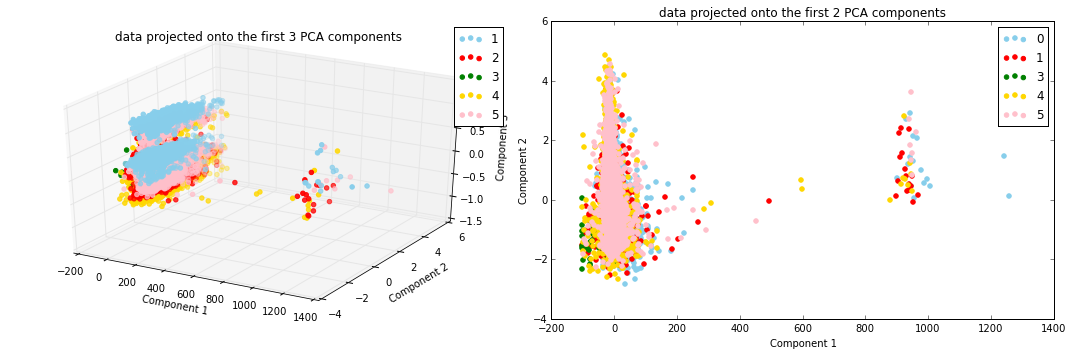

In [97]:
#Apply PCA to data and get the top 3 axes of maximum variation
pca = PCA(n_components=3)
pca.fit(X_train)

#Project to the data onto the three axes
x_reduced = pca.transform(X_train)

#Visualized our reduced data
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(1, 2, 1,  projection='3d')
ax1.scatter(x_reduced[y==1, 0], x_reduced[y==1, 1], x_reduced[y==1, 2], c='skyblue', color='skyblue', label='1')
ax1.scatter(x_reduced[y==2, 0], x_reduced[y==2, 1], x_reduced[y==2, 2], c='r', color='r', label='2')
ax1.scatter(x_reduced[y==3, 0], x_reduced[y==3, 1], x_reduced[y==3, 2], c='g', color='g', label='3')
ax1.scatter(x_reduced[y==4, 0], x_reduced[y==4, 1], x_reduced[y==4, 2], c='gold', color='gold', label='4')
ax1.scatter(x_reduced[y==5, 0], x_reduced[y==5, 1], x_reduced[y==5, 2], c='pink', color='pink', label='5')

ax1.set_xlabel('Component 1')
ax1.set_ylabel('Component 2')
ax1.set_zlabel('Component 3')
ax1.set_title('data projected onto the first 3 PCA components')
ax1.legend()

#Apply PCA to data and get the top 2 axes of maximum variation
pca = PCA(n_components=2)
pca.fit(X_train)

#Project to the data onto the three axes
x_reduced = pca.transform(X_train)

#Visualized our reduced data
ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(x_reduced[y==1, 0], x_reduced[y==1, 1], c='skyblue', color='skyblue', label='0')
ax2.scatter(x_reduced[y==2, 0], x_reduced[y==2, 1], c='r', color='r', label='1')
ax2.scatter(x_reduced[y==3, 0], x_reduced[y==3, 1], c='g', color='g', label='3')
ax2.scatter(x_reduced[y==4, 0], x_reduced[y==4, 1], c='gold', color='gold', label='4')
ax2.scatter(x_reduced[y==5, 0], x_reduced[y==5, 1], c='pink', color='pink', label='5')

ax2.set_xlabel('Component 1')
ax2.set_ylabel('Component 2')
ax2.set_title('data projected onto the first 2 PCA components')
ax2.legend()

plt.tight_layout()
plt.show()

As shown in PCA plot, it's hard to differentiate the five genre classes via top 2-3 PCA components. Since we only have **29** features in out dataset, we probably won't use PCA to reduce the dimension for modeling in order to get better interpretability.